In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

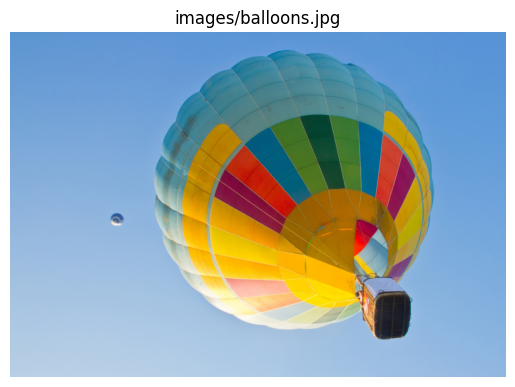

In [3]:
# read img（ BGR ）
img = cv2.imread('images/balloons.jpg')
# BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# show img（ RGB ）
plt.imshow(img_rgb)
plt.title("images/balloons.jpg")
plt.axis('off')
plt.show()

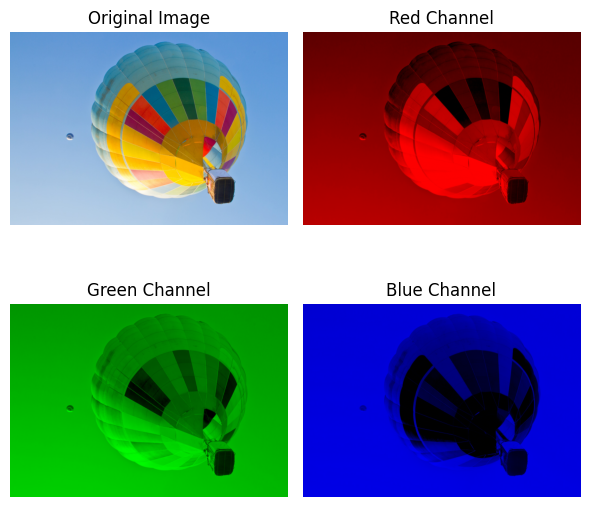

In [5]:
# 擷取 R, G, B 三個通道

R = img_rgb.copy()
R[:, :, 1:] = 0  # clean G,B

G = img_rgb.copy()
G[:, :, [0,2]] = 0  # clean R,B

B = img_rgb.copy()
B[:, :, :2] = 0  # clean R, G

# plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title("Original Image")
axes[0, 1].imshow(R)
axes[0, 1].set_title("Red Channel")

axes[1, 0].imshow(G)
axes[1, 0].set_title("Green Channel")
axes[1, 1].imshow(B)
axes[1, 1].set_title("Blue Channel")

# remove axis
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

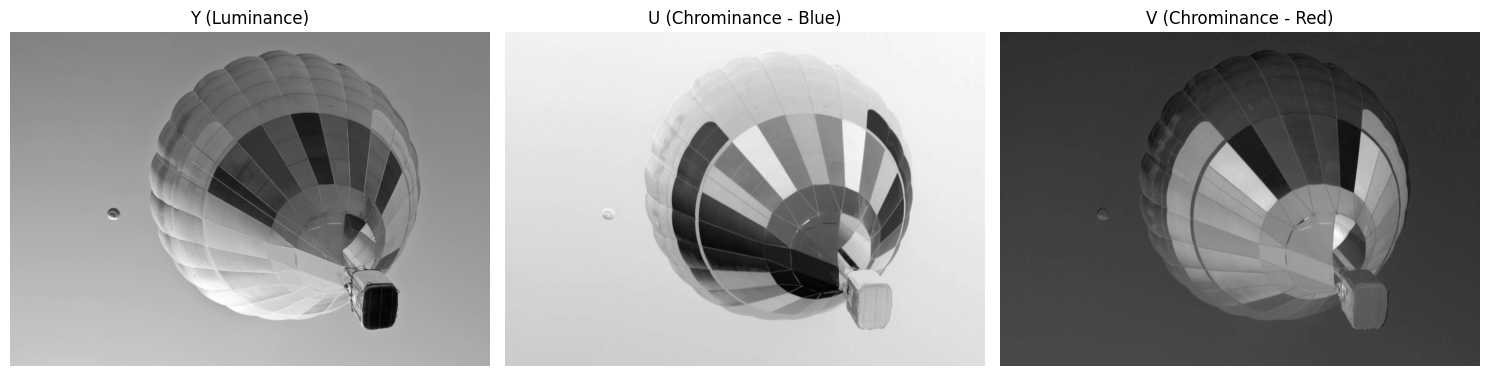

In [6]:
img_rgb_normal = img_rgb.astype(np.float32) / 255.0  # 正規化到 [0, 1]

Rn = img_rgb_normal[:, :, 0]
Gn = img_rgb_normal[:, :, 1]
Bn = img_rgb_normal[:, :, 2]

Y = 0.299 * Rn + 0.587 * Gn + 0.114 * Bn
U = -0.14713 * Rn - 0.28886 * Gn + 0.436 * Bn
V = 0.615 * Rn - 0.51499 * Gn - 0.10001 * Bn

# normalization
U_display = (U - U.min()) / (U.max() - U.min())
V_display = (V - V.min()) / (V.max() - V.min())

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(Y*255, cmap='gray')
axes[0].set_title("Y (Luminance)")

axes[1].imshow(U_display*255, cmap='gray')
axes[1].set_title("U (Chrominance - Blue)")

axes[2].imshow(V_display*255, cmap='gray')
axes[2].set_title("V (Chrominance - Red)")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

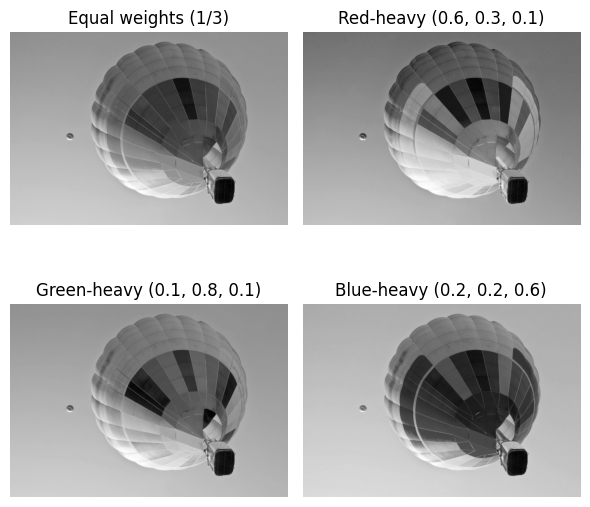

In [8]:
# Define weights
weights = {
    "Equal weights (1/3)": (1/3, 1/3, 1/3),
    "Red-heavy (0.6, 0.3, 0.1)": (0.6, 0.3, 0.1),
    "Green-heavy (0.1, 0.8, 0.1)": (0.1, 0.8, 0.1),
    "Blue-heavy (0.2, 0.2, 0.6)": (0.2, 0.2, 0.6),
}

grayscale_images = []
for label, (wr, wg, wb) in weights.items():
    gray = wr * Rn + wg * Gn + wb * Bn
    grayscale_images.append((gray, label))

# plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, (gray_img, title) in zip(axes.flat, grayscale_images):
    ax.imshow(gray_img*255, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

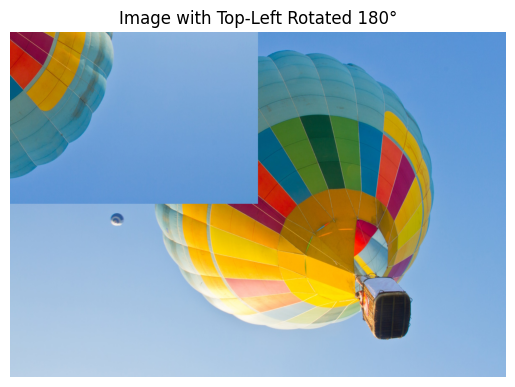

In [9]:
H, W, _ = img_rgb.shape
h_half, w_half = H // 2, W // 2

img_modified = img_rgb.copy()

# 1/4 of left corner
top_left = img_rgb[0:h_half, 0:w_half]

# upside down then flip left and right
rotated = top_left[::-1, ::-1]

img_modified[0:h_half, 0:w_half] = rotated

# plot
plt.imshow(img_modified)
plt.title("Image with Top-Left Rotated 180°")
plt.axis('off')
plt.show()

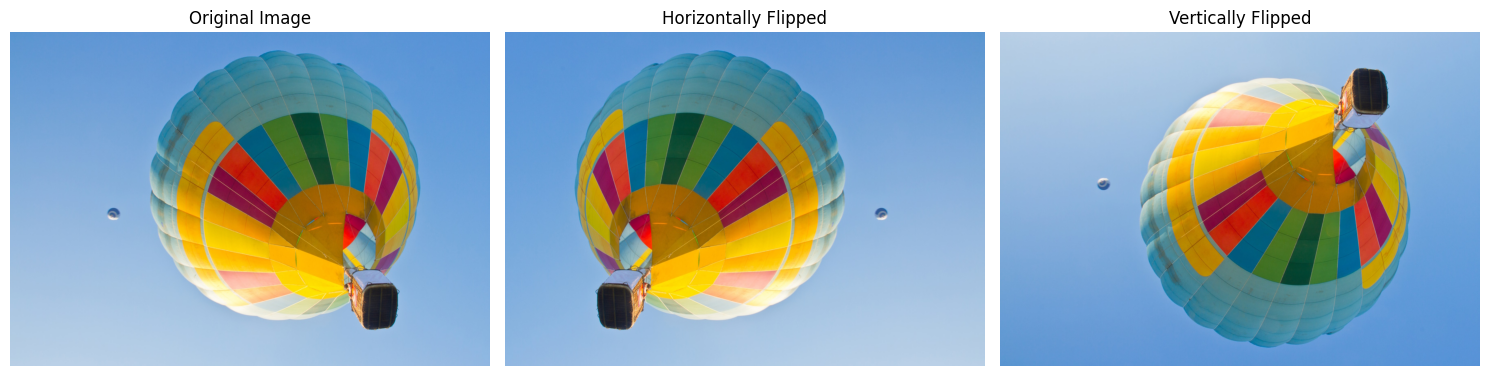

In [11]:
horizontal_flip = np.zeros_like(img_rgb)
vertical_flip = np.zeros_like(img_rgb)

# flip left and right
for i in range(H):
    for j in range(W):
        horizontal_flip[i, j] = img_rgb[i, W - 1 - j]

# upside down
for i in range(H):
    for j in range(W):
        vertical_flip[i, j] = img_rgb[H - 1 - i, j]

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ['Original Image', 'Horizontally Flipped', 'Vertically Flipped']
images = [img_rgb, horizontal_flip, vertical_flip]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

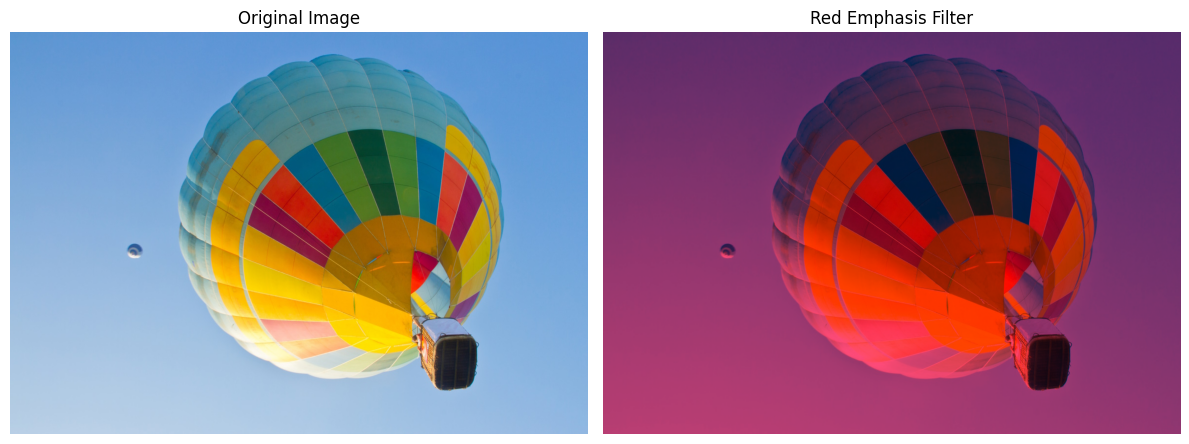

In [14]:
# keep red then 0.3 for G & 0.5 for  B
red_emphasis = img_rgb_normal.copy()
red_emphasis[:, :, 1] *= 0.3  # G 通道
red_emphasis[:, :, 2] *= 0.5  # B 通道

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[1].imshow((red_emphasis * 255).astype(np.uint8))
axes[1].set_title("Red Emphasis Filter")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Problem 1h – 自訂色彩增強方法：HSV 飽和度 Gamma 增強

#### 方法原理：
從 $RGB$ 色彩空間轉換為 $HSV，S$ channel 代表色彩的飽和程度。
對 $S$ 通道進行非線性調整，以提升圖像的視覺對比與飽和感。

使用 gamma 增強函數：$S_{\text{new}} = S^\gamma$ ，其中 $\gamma < 1$ 時，會提升低飽和區域，讓整體色彩更加鮮明，但不會過度強化本來就飽和的部分。\
( $\gamma > 1$：抑制低飽和度區域，整體色彩變得更柔和、更淡化。)

### RGB → HSV 色彩空間轉換

假設輸入的 $R, G, B \in [0, 1]$，我們可以使用以下公式將每個像素從 RGB 色彩空間轉換成 HSV：

---

#### 1. 最大最小值與差值
$C_{\text{max}} = \max(R, G, B)$\
$C_{\text{min}} = \min(R, G, B)$\
$\Delta = C_{\text{max}} - C_{\text{min}}$

---

#### 2. $H$ : Hue
角度（以色環為基礎），單位是度數\
$R$ 段從 $0^\circ$ 開始\
$G$ 段從 $120^\circ$ 開始\
$B$ 段從 $240^\circ$ 開始\
$H = \begin{cases}
0, & \text{if } \Delta = 0 \\
60^\circ \cdot \left( \frac{G - B}{\Delta} \bmod 6 \right), & \text{if } C_{\text{max}} = R \\
60^\circ \cdot \left( \frac{B - R}{\Delta} + 2 \right), & \text{if } C_{\text{max}} = G \\
60^\circ \cdot \left( \frac{R - G}{\Delta} + 4 \right), & \text{if } C_{\text{max}} = B \\
\end{cases}
$

通常 Hue $ H $ 取值範圍為 $[0, 360^\circ]$，若與 OpenCV 相容可除以 2 縮放至 $[0, 180^\circ]$。

---

#### 3. $S$ : Saturation
飽和度

$
S = 
\begin{cases}
0, & \text{if } C_{\text{max}} = 0 \\
\frac{\Delta}{C_{\text{max}}}, & \text{o.w}
\end{cases}
$

---

#### 4. $V$ : Value
明度

$V = C_{\text{max}}$

---

#### HSV → RGB 的反轉公式有待試做。先用OpenCV


In [17]:
def rgb_to_hsv(img_rgb):
    """
    RGB to HSV。
    input: img_rgb：np.ndarray, float32, shape = (H, W, 3)，value in [0, 1]
    output: img_hsv：np.ndarray, float32, shape = (H, W, 3)，H in [0, 360], S, V in [0, 1]
    """
    R = img_rgb[:, :, 0]
    G = img_rgb[:, :, 1]
    B = img_rgb[:, :, 2]
    
    # element-wise
    Cmax = np.maximum(np.maximum(R, G), B)
    Cmin = np.minimum(np.minimum(R, G), B)
    delta = Cmax - Cmin

    H = np.zeros_like(Cmax)

    # np.where() will calculate first -> divide by 0
    mask = delta != 0
    mask_r = (Cmax == R) & mask
    mask_g = (Cmax == G) & mask
    mask_b = (Cmax == B) & mask
    
    # 分段安全計算 Hue
    H[mask_r] = 60 * (((G[mask_r] - B[mask_r]) / delta[mask_r]) % 6)
    H[mask_g] = 60 * (((B[mask_g] - R[mask_g]) / delta[mask_g]) + 2)
    H[mask_b] = 60 * (((R[mask_b] - G[mask_b]) / delta[mask_b]) + 4)

    # Saturation calculation
    S = np.where(Cmax != 0, delta / Cmax, 0)

    # Value calculation
    V = Cmax

    # 組合回 HSV 圖片
    img_hsv = np.stack([H, S, V], axis=2)
    return img_hsv

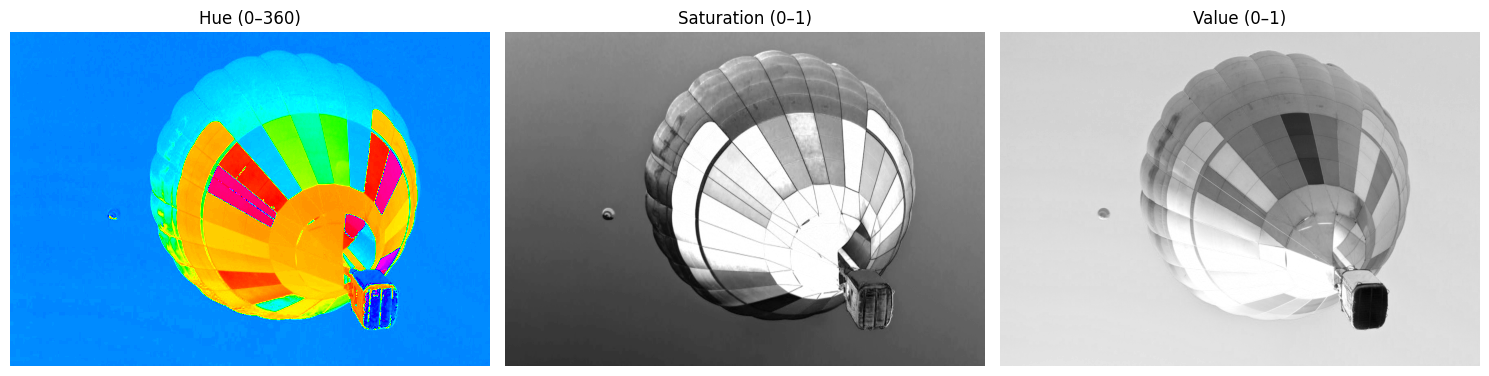

In [19]:
# 使用自訂函數轉 HSV
img_hsv = rgb_to_hsv(img_rgb_normal)

# 顯示 H, S, V
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Hue (0–360)', 'Saturation (0–1)', 'Value (0–1)']
cmaps = ['hsv', 'gray', 'gray']

for ax, channel, title, cmap in zip(axes, range(3), titles, cmaps):
    ax.imshow(img_hsv[:, :, channel], cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

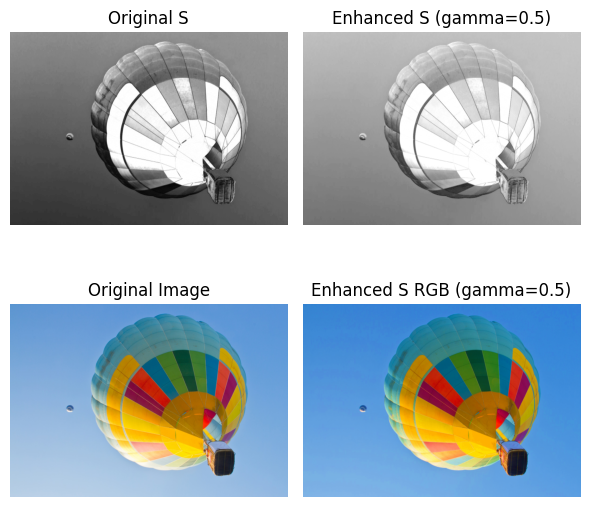

In [22]:
img_hsv = rgb_to_hsv(img_rgb_normal)
H, S, V = img_hsv[:, :, 0], img_hsv[:, :, 1], img_hsv[:, :, 2]

# 對 S 做 gamma 增強
gamma = 0.5
S_new = np.clip(S ** gamma, 0, 1)

H_cv = (H / 2).clip(0, 179)       # H: 0~360 -> 0~179
S_cv = (S_new * 255).clip(0, 255) # S: 0~1 -> 0~255
V_cv = (V * 255).clip(0, 255)     # V: 0~1 -> 0~255

# Use OpenCV HSV to RGB
img_hsv_cv = np.stack([H_cv, S_cv, V_cv], axis=2).astype(np.uint8)
img_rgb_enhanced = cv2.cvtColor(img_hsv_cv, cv2.COLOR_HSV2RGB)

# plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(S, cmap='gray')
axes[0, 0].set_title("Original S")
axes[0, 1].imshow(S_new, cmap='gray')
axes[0, 1].set_title(f"Enhanced S (gamma={gamma})")

axes[1, 0].imshow(img_rgb)
axes[1, 0].set_title("Original Image")
axes[1, 1].imshow(img_rgb_enhanced)
axes[1, 1].set_title(f"Enhanced S RGB (gamma={gamma})")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

 $\gamma = 0.5$。

#### 增強結果：
- 原圖色彩自然但部分區域較黯淡。
- 經過飽和度增強後，整體圖像更鮮明，熱氣球與天空的對比更加明顯。
- 保留了原有色調，但提升了主體的吸引力。

#### 方法步驟摘要：
1. 將 RGB 影像轉換為 HSV。
2. 對 S 通道進行 $\gamma$ 增強（本例為 $\gamma=0.5$）。
3. 將增強後的 HSV 再轉回 RGB。